# Predcition of Hospital Admission Related to Combination of Upper Respiratory Tract Infections 

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to combination of Upper Respiratory Tract Infections (urti_combined). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process urti_combined data
def proc_infec_data_combined_urti(data, infection):
    #rename variables with i
    for i in range(1,21):
        data.rename(columns={infection+'_date_'+str(i): 'urti_combined_date_'+str(i), infection+'_ab_date_'+str(i): 'urti_combined_ab_date_'+str(i),
                            infection+'_ab_type_'+str(i): 'urti_combined_ab_type_'+str(i), 'incdt_'+infection+'_date_'+str(i): 'incdt_urti_combined_date_'+str(i), 
                            'incdt_'+infection+'_type_'+str(i): 'incdt_urti_combined_type_'+str(i), 'admitted_'+infection+'_date_'+str(i): 'admitted_urti_combined_date_'+str(i),
                            'gp_covid_date_'+infection+'_'+str(i): 'gp_covid_date_combined_urti_'+str(i), 'sgss_gp_cov_'+infection+'_date_'+str(i): 'sgss_gp_cov_urti_combined_date_'+str(i),
                            'sgss_pos_covid_date_'+infection+'_'+str(i): 'sgss_pos_covid_date_urti_combined_'+str(i), infection+'_ab_count_'+str(i): 'urti_combined_ab_count_'+str(i)},
                    inplace=True)
    
    return data

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_combined_date_'+str(i), 'urti_combined_ab_date_'+str(i), 'urti_combined_ab_type_'+str(i),
                   'incdt_urti_combined_date_'+str(i), 'admitted_urti_combined_date_'+str(i), 'sgss_gp_cov_urti_combined_date_'+str(i)]]
    
    #drop rows with no urti_combined reord
    datum = datum[datum['urti_combined_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_combined_i
    datum = datum[datum['sgss_gp_cov_urti_combined_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_combined_date_'+str(i): 'urti_combined_date', 'urti_combined_ab_date_'+str(i): 'urti_combined_ab_date', 
                           'urti_combined_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_combined_date_'+str(i): 'incdt_urti_combined_date', 'incdt_urti_combined_type_'+str(i): 'incdt_urti_combined_type',
                           'admitted_urti_combined_date_'+str(i): 'admitted_urti_combined_date',
                           'sgss_gp_cov_urti_combined_date_'+str(i): 'sgss_gp_cov_urti_combined_date'},
                inplace=True)
    
    return datum

In [6]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_urti_combined_admitted',
            event_col='event_urti_combined_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_urti_combined_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)
    
    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)

    #save prob_pred for analysis in r
    prob_pred.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis.csv', index=False)

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    #save prob_pred_enc_lr_rf for analysis in r
    prob_pred_enc_lr_rf.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis_binned.csv', index=False)

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier()#n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #caculate ORs and intervals of LR model, save and print them 
    # lr_coef = pd.DataFrame({"or": lr.coef_})#, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef_exp = np.exp(lr_coef)
    # lr_coef_exp.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    # lr_coef = lr.coef_
    # print('LR ORs:\n %s'%(lr_coef))
    # lr_coef = pd.DataFrame(data=np.exp(lr.coef_), index=data_enc_dev_x.columns, columns=['lr_coef'])
    # lr_coef = lr_coef.sort_values('lr_coef', ascending=False)
    # lr_coef = pd.DataFrame(data=lr.coef_.T, index=data_enc_dev_x.columns, columns=['lr_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # # lr_coef['lr_coef_lower_bound'] = st.norm.ppf(lr_coef['lr_coef'])
    alpha = 0.05
    #the coefficients of the regression model
    coefs = np.r_[lr.coef_.T.tolist()]#[lr.intercept_], lr.coef_.T.tolist()
    #build an auxiliary dataframe with the constant term in it
    X_aux = data_enc_dev_x.copy()
    # X_aux.insert(0, 'const', 1)
    #degrees of freedom
    dof = -np.diff(X_aux.shape)[0]
    #Student's t-distribution table lookup
    t_val = stats.t.isf(alpha/2, dof)
    #MSE of the residuals
    mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
    #inverse of the variance of the parameters
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    #distance between lower and upper bound of CI
    gap = t_val * np.sqrt(mse * var_params)
    lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
    lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
    # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
    lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR ORs:\n %s'%(lr_coef_ors_ints))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # rf_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR model with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [9]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    # #print summary of LR model
    # lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef = np.exp(lr_coef)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    # print('LR coefficients:\n %s'%(lr_coef))
    alpha = 0.05
    #the coefficients of the regression model
    coefs = np.r_[lr.coef_.T.tolist()] #[lr.intercept_], lr.coef_.T.tolist()
    #build an auxiliary dataframe with the constant term in it
    X_aux = data_enc_dev_x.copy()
   #  X_aux.insert(0, 'const', 1)
    #degrees of freedom
    dof = -np.diff(X_aux.shape)[0]
    #Student's t-distribution table lookup
    t_val = stats.t.isf(alpha/2, dof)
    #MSE of the residuals
    mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
    #inverse of the variance of the parameters
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    #distance between lower and upper bound of CI
    gap = t_val * np.sqrt(mse * var_params)
    lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
    lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
    # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
    lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR ORs:\n %s'%(lr_coef_ors_ints))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [10]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val):#, rf_pred_dev, rf_pred_val):
    # ##calibration for RF
    # rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    # #
    # rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    # #plot calibration plot for RF model with development and validation data
    # fig, ax1 = plt.subplots(figsize=(7, 7))
    # plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    # plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    # plt.xlabel('Mean predicted probabilities', fontsize=14)
    # plt.ylabel('Proportion of observed values', fontsize=14)
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=12, rotation=0)
    # plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    # plt.title("Calibration plot of RF model", fontsize=14)
    # legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    # legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    # plt.legend(handles=[legend_dev, legend_val])
    # plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    # plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [11]:
#read datasets 
data_urti = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')
data_cough = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')
data_cough_cold = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')
data_throat = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [12]:
#convert data into combined_urti and concatenate them
data_urti_converted = proc_infec_data_combined_urti(data_urti, 'urti')
data_cough_converted = proc_infec_data_combined_urti(data_cough, 'cough')
data_cough_cold_converted = proc_infec_data_combined_urti(data_cough_cold, 'cough_cold')
data_throat_converted = proc_infec_data_combined_urti(data_throat, 'throat')

frames = [data_urti_converted, data_cough_converted, data_cough_cold_converted, data_throat_converted]
data = pd.concat(frames)

In [13]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [14]:
#process 20 urti_combineds and concatenate them 
data_urti_combined_1 = proc_infec_data(data,1)
data_urti_combined_2 = proc_infec_data(data,2)
data_urti_combined_3 = proc_infec_data(data,3)
data_urti_combined_4 = proc_infec_data(data,4)
data_urti_combined_5 = proc_infec_data(data,5)
data_urti_combined_6 = proc_infec_data(data,6)
data_urti_combined_7 = proc_infec_data(data,7)
data_urti_combined_8 = proc_infec_data(data,8)
data_urti_combined_9 = proc_infec_data(data,9)
data_urti_combined_10 = proc_infec_data(data,10)
data_urti_combined_11 = proc_infec_data(data,11)
data_urti_combined_12 = proc_infec_data(data,12)
data_urti_combined_13 = proc_infec_data(data,13)
data_urti_combined_14 = proc_infec_data(data,14)
data_urti_combined_15 = proc_infec_data(data,15)
data_urti_combined_16 = proc_infec_data(data,16)
data_urti_combined_17 = proc_infec_data(data,17)
data_urti_combined_18 = proc_infec_data(data,18)
data_urti_combined_19 = proc_infec_data(data,19)
data_urti_combined_20 = proc_infec_data(data,20)

data_urti_combined = pd.concat([data_urti_combined_1, data_urti_combined_2, data_urti_combined_3, data_urti_combined_4, data_urti_combined_5, data_urti_combined_6, data_urti_combined_7, data_urti_combined_8, data_urti_combined_9, data_urti_combined_10, data_urti_combined_11, data_urti_combined_12, data_urti_combined_13, data_urti_combined_14, data_urti_combined_15, data_urti_combined_16, data_urti_combined_17, data_urti_combined_18, data_urti_combined_19, data_urti_combined_20])
data_urti_combined.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [15]:
##add variable season
#convert data types
data_urti_combined['urti_combined_date'] = data_urti_combined['urti_combined_date'].astype('datetime64[ns]')
data_urti_combined['admitted_urti_combined_date'] = data_urti_combined['admitted_urti_combined_date'].astype('datetime64[ns]')
data_urti_combined.died_date = data_urti_combined.died_date.astype('datetime64[ns]')
data_urti_combined.deregistered_date = data_urti_combined.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti_combined['date'] = data_urti_combined['urti_combined_date'] 
data_urti_combined['date'] = data_urti_combined['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti_combined with today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_1_month_date_y_m]
data_urti_combined = data_urti_combined[data_urti_combined['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti_combined records
data_urti_combined['season'] = np.nan
data_urti_combined['date_month'] = pd.DatetimeIndex(data_urti_combined['date']).month

conditions = [
    (data_urti_combined['date_month'] >= 3) & (data_urti_combined['date_month'] <= 5),
    (data_urti_combined['date_month'] >= 6) & (data_urti_combined['date_month'] <= 8),
    (data_urti_combined['date_month'] >= 9) & (data_urti_combined['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti_combined['season'] = np.select(conditions, choices, default='winter')

In [16]:
#add variable time period
data_urti_combined.loc[(data_urti_combined['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti_combined.loc[((data_urti_combined['date'] >= '2020-05') & (data_urti_combined['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_urti_combined.loc[(data_urti_combined['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

In [17]:
data_urti_combined['date'].max()

'2023-04'

#### event and duration

In [18]:
#scenario 1
#not hosped (nothing happened)
data_urti_combined.loc[data_urti_combined['admitted_urti_combined_date'].isnull(), 'event_urti_combined_admitted'] = 0

In [19]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti_combined['delta_urti_combined_admitted'] = (data_urti_combined['admitted_urti_combined_date'] - data_urti_combined['urti_combined_date']).dt.days
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] >= 0) & (data_urti_combined['delta_urti_combined_admitted'] <= 30)), 'event_urti_combined_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti_combined consultation, i.e. negative value for delta_urti_combined_admitted
data_urti_combined = data_urti_combined[~(data_urti_combined['delta_urti_combined_admitted'] < 0)]

In [20]:
#scenario 3
#censor died patients
data_urti_combined['delta_admitted_died'] = (data_urti_combined['died_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_died'] >= 0) & (data_urti_combined['delta_admitted_died'] <= 30)), 'event_urti_combined_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti_combined['delta_admitted_deregistered'] = (data_urti_combined['deregistered_date'] - data_urti_combined['admitted_urti_combined_date']).dt.days
data_urti_combined.loc[data_urti_combined['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti_combined.loc[((data_urti_combined['delta_admitted_deregistered'] > 0) & (data_urti_combined['delta_admitted_deregistered'] <= 30)), 'event_urti_combined_admitted'] = 0

#agg scenario 3s
data_urti_combined['delta_admitted_died_deregistered'] = data_urti_combined['delta_admitted_deregistered'].combine_first(data_urti_combined['delta_admitted_died'])
data_urti_combined.loc[data_urti_combined['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [21]:
#scenario 1
#any other patients (nothing happened)
data_urti_combined['event_urti_combined_admitted'] = data_urti_combined['event_urti_combined_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['delta_urti_combined_admitted'].combine_first(data_urti_combined['delta_admitted_died_deregistered'])
data_urti_combined['duration_urti_combined_admitted'] = data_urti_combined['duration_urti_combined_admitted'].replace(np.NaN, 30)
data_urti_combined.loc[(data_urti_combined['duration_urti_combined_admitted'] > 30), 'duration_urti_combined_admitted'] = 30

#give value 1 to event_urti_combined_admitted if duration_urti_combined_admitted is greater or equal to 0 and less than 30
data_urti_combined.loc[((data_urti_combined['duration_urti_combined_admitted'] >= 0) & (data_urti_combined['duration_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti_combined = data_urti_combined[~(data_urti_combined['duration_urti_combined_admitted'] == 0)]

In [22]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti_combined.loc[((data_urti_combined['delta_urti_combined_admitted'] > 0) & (data_urti_combined['delta_urti_combined_admitted'] < 30)), 'event_urti_combined_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [23]:
#drop anybody with age less than 18 or 0!
data_urti_combined = data_urti_combined[~(data_urti_combined['age'] < 18)] 
data_urti_combined['age'][data_urti_combined['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '0-4']
data_urti_combined = data_urti_combined[data_urti_combined['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti_combined['bmi'][data_urti_combined['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti_combined['bmi'] = data_urti_combined['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti_combined['antibacterial_brit'][data_urti_combined['antibacterial_brit'] < 0] = np.nan

In [24]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"smoking": dict_smoking})

In [25]:
#drop rows with missing region
if ('region' in data_urti_combined.columns) and (data_urti_combined['region'].isnull().sum() > 0):
   data_urti_combined = data_urti_combined[data_urti_combined['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti_combined.columns) and (data_urti_combined['antibacterial_brit'].isnull().sum() > 0):
    data_urti_combined['antibacterial_brit'] = data_urti_combined['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti_combined.columns) and (data_urti_combined['ethnicity'].isnull().sum() > 0):
    data_urti_combined['ethnicity'] = data_urti_combined['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_urti_combined.columns) and (data_urti_combined['smoking'].isnull().sum() > 0):
    data_urti_combined['smoking'] = data_urti_combined['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti_combined.columns) and (data_urti_combined['imd'].isnull().sum() > 0):
    data_urti_combined['imd'] = data_urti_combined['imd'].fillna(0)

In [26]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti_combined['bmi_cat'] = 5

for idx, x in enumerate(data_urti_combined['bmi_cat']):
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 30:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 25) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 30):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] >= 18.5) and (data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 25):
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi')] < 18.5:
        data_urti_combined.iat[idx, data_urti_combined.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti_combined.columns) and (data_urti_combined['bmi_cat'].isnull().sum() > 0):
    data_urti_combined['bmi_cat'] = data_urti_combined['bmi_cat'].fillna(0)

In [27]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti_combined.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti_combined['ab_type_cat'] = np.where(data_urti_combined['ab_type'].isin(ab_series[mask].index),'other',data_urti_combined['ab_type'])
#assign no to non ab users
data_urti_combined.loc[data_urti_combined['urti_combined_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti_combined['ab_type_cat'] = data_urti_combined['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [28]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti_combined = data_urti_combined.replace({"sex": dict_sex})
data_urti_combined = data_urti_combined.replace({"ethnicity": dict_ethnicity})
data_urti_combined = data_urti_combined.replace({"smoking": dict_smoking})
data_urti_combined = data_urti_combined.replace({"imd": dict_imd})
data_urti_combined = data_urti_combined.replace({"bmi_cat": dict_bmi})
data_urti_combined = data_urti_combined.replace({"flu_vaccine": dict_flu})
data_urti_combined = data_urti_combined.replace({"region": dict_region})
data_urti_combined = data_urti_combined.replace({"age_cat": dict_age})
data_urti_combined = data_urti_combined.replace({"ab_type_cat": dict_ab_type})

In [29]:
data_urti_combined.ethnicity.value_counts('NA')

white      0.600551
unknown    0.249622
other      0.075213
asian      0.074614
Name: ethnicity, dtype: float64

In [30]:
data_urti_combined.smoking.value_counts('NA')

unknown         0.414333
smoker          0.390880
never_smoked    0.129622
ex_smoker       0.065166
Name: smoking_status, dtype: float64

In [31]:
data_urti_combined.bmi_cat.value_counts('NA')

obese             0.518999
unknown           0.255273
overweight        0.112371
healthy_weight    0.081276
underweight       0.032081
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [32]:
#categorise CCI
data_urti_combined['CCI_cat'] = pd.cut(data_urti_combined['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti_combined['antibacterial_brit'].clip(0, data_urti_combined['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

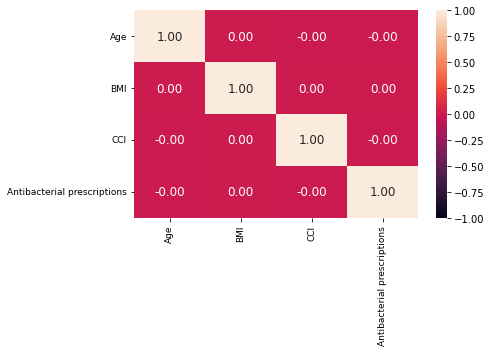

In [33]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti_combined[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti_combined/corr_urti_combined.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [34]:
data_urti_combined = data_urti_combined[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'urti_combined_ab_date', 'ab_type_cat', 'incdt_urti_combined_date', 'date', 'period',
                                   'event_urti_combined_admitted', 'duration_urti_combined_admitted'
                                    ]]

In [35]:
#switch variable urti_combined_ab_date into a binary variable
data_urti_combined[['ab_binary']] = data_urti_combined[['urti_combined_ab_date']].where(data_urti_combined[['urti_combined_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_urti_combined_incdt = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 0]
data_urti_combined_prevl = data_urti_combined[data_urti_combined['incdt_urti_combined_date'] == 1]

#no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt = data_urti_combined_incdt[data_urti_combined_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_urti_combined_abs_incdt = data_urti_combined_incdt[data_urti_combined_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_urti_combined_no_abs_prevl = data_urti_combined_prevl[data_urti_combined_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_urti_combined_abs_prevl = data_urti_combined_prevl[data_urti_combined_prevl['ab_binary'] == 1]

In [36]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_urti_combined_incdt_prepandemic = data_urti_combined_incdt[data_urti_combined_incdt['period'] == 'prepandemic']
data_urti_combined_incdt_during_pandemic = data_urti_combined_incdt[(data_urti_combined_incdt['period'] == 'during_pandemic')]
data_urti_combined_incdt_post_2nd_lockdown = data_urti_combined_incdt[data_urti_combined_incdt['period'] == 'post_2nd_lockdown']
data_urti_combined_prevl_prepandemic = data_urti_combined_prevl[data_urti_combined_prevl['period'] == 'prepandemic']
data_urti_combined_prevl_during_pandemic = data_urti_combined_prevl[(data_urti_combined_prevl['period'] == 'during_pandemic')]
data_urti_combined_prevl_post_2nd_lockdown = data_urti_combined_prevl[data_urti_combined_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_urti_combined_no_abs_incdt_prepandemic = data_urti_combined_incdt_prepandemic[data_urti_combined_incdt_prepandemic['ab_binary'] == 0]
data_urti_combined_no_abs_incdt_during_pandemic = data_urti_combined_incdt_during_pandemic[data_urti_combined_incdt_during_pandemic['ab_binary'] == 0]
data_urti_combined_no_abs_incdt_post_2nd_lockdown = data_urti_combined_incdt_post_2nd_lockdown[data_urti_combined_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_prepandemic = data_urti_combined_prevl_prepandemic[data_urti_combined_prevl_prepandemic['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_during_pandemic = data_urti_combined_prevl_during_pandemic[data_urti_combined_prevl_during_pandemic['ab_binary'] == 0]
data_urti_combined_no_abs_prevl_post_2nd_lockdown = data_urti_combined_prevl_post_2nd_lockdown[data_urti_combined_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [37]:
#store data for plotting hosp admission counts and percentages
%store data_urti_combined
# save data
data_urti_combined.to_csv('../output/hospitalisation_prediction_urti_combined/data_urti_combined.csv')

Stored 'data_urti_combined' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [38]:
# #make summary tables
# make_summary_table('urti_combined', 'no_abs_incdt', data_urti_combined_no_abs_incdt)
# # make_summary_table('urti_combined', 'abs_incdt', data_urti_combined_abs_incdt)
# make_summary_table('urti_combined', 'no_abs_prevl', data_urti_combined_no_abs_prevl)
# make_summary_table('urti_combined', 'abs_prevl', data_urti_combined_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 438879 total observations, 436039 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 438879
number of events observed = 2840
   partial log-likelihood = -36867.94
         time fit was run = 2023-07-31 08:37:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.00       1.00       0.06            -0.11             0.12                 0.90                 1.12
CCI_cat[T.medium]                0.12       1.12       0.06            -0.00             0.24                 1.00                 1.27
CCI_cat[T.high]                  0.04       1.04       0.07            -0.11             0.18                 0.90                 1.20
CCI_cat[T.very_high]             0.05       1.05       0.07            -0.08             0.18                 0.92                 1.19
age_cat[T.25_34]                 0.04       1.04       0.07            -0.10             0.18                 0.91                 1.20
age_cat[T.35_44]                 0.09       1.10       0.07            -0.04             0.23                 0.96                 1.26
age_cat[T.45_54]                 0.01       1.01       0.07            -0.13             0.15                 0.88                 1.16
age_cat[T.55_64]                -0.01       0.99       0.07            -0.15             0.13                 0.86                 1.14
age_cat[T.65_74]                 0.05       1.05       0.07            -0.09             0.19                 0.91                 1.21
age_cat[T.75_more]               0.06       1.06       0.07            -0.08             0.20                 0.92                 1.22
antibacterial_brit               0.01       1.01       0.01            -0.02             0.03                 0.98                 1.03
bmi_cat[T.obese]                 0.01       1.01       0.07            -0.13             0.14                 0.88                 1.15
bmi_cat[T.overweight]           -0.08       0.92       0.09            -0.26             0.09                 0.77                 1.09
bmi_cat[T.underweight]           0.08       1.08       0.12            -0.16             0.31                 0.85                 1.37
bmi_cat[T.unknown]               0.01       1.01       0.08            -0.14             0.15                 0.87                 1.17
ethnicity[T.other]               0.11       1.12       0.10            -0.08             0.30                 0.92                 1.35
ethnicity[T.unknown]            -0.08       0.93       0.08            -0.23             0.08                 0.79                 1.08
ethnicity[T.white]               0.05       1.06       0.07            -0.09             0.20                 0.91                 1.22
flu_vaccine[T.yes]              -0.06       0.94       0.06            -0.19             0.06                 0.83                 1.07
imd[T.medium]                    0.01       1.01       0.06            -0.11             0.13                 0.90                 1.14
imd[T.unaffluent]               -0.06       0.94       0.06            -0.18             0.06                 0.83                 1.06
imd[T.unknown]                   0.06       1.06       0.09            -0.12             0.24                 0.89                 1.27
imd[T.very_affluent]            -0.06       0.95       0.06            -0.17             0.06                 0.84                 1.07
imd[T.very_unaffluent]          -0.07       0.93       0.06            -0.19             0.05                 0.83                 1.05
region[T.east_midlands]         -0.13       0

13062


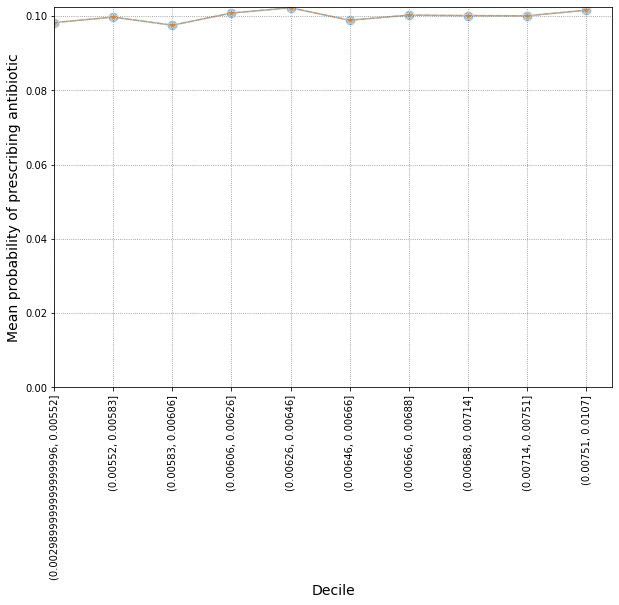


AUROC of LR for deciles with development and validation data: 0.50543 and 0.49942
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00552, 0.00583]  0.003292    0.000484    0.006100  1.003297   
bins_(0.00583, 0.00606] -0.015681   -0.018493   -0.012869  0.984441   
bins_(0.00606, 0.00626]  0.032774    0.029967    0.035582  1.033317   
bins_(0.00626, 0.00646]  0.055315    0.052508    0.058121  1.056873   
bins_(0.00646, 0.00666]  0.005384    0.002580    0.008189  1.005399   
bins_(0.00666, 0.00688]  0.002143   -0.000660    0.004946  1.002145   
bins_(0.00688, 0.00714]  0.018595    0.015789    0.021400  1.018768   
bins_(0.00714, 0.00751]  0.014408    0.011600    0.017216  1.014512   
bins_(0.00751, 0.0107]   0.033720    0.030916    0.036524  1.034295   

                         ors_lower  ors_upper  
bins_(0.00552, 0.00583]   1.000484   1.006119  
bins_(0.00583, 0.00606]   0.981677   0.987213  
bins_(0.00606, 0.00626]   1.030420   1.036223  
bins_

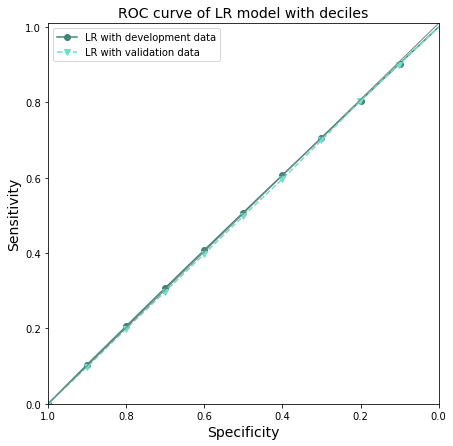

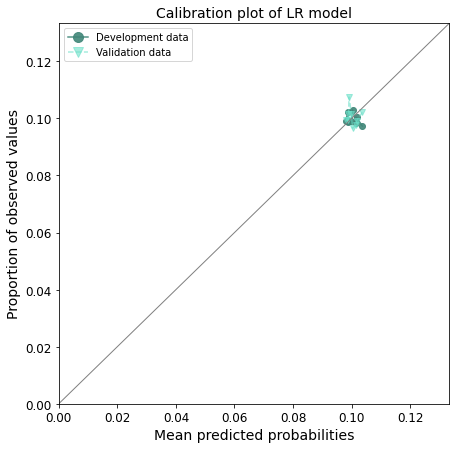


AUROC of LR for risk factors with development and validation data: 0.50818 and 0.49911
LR ORs:
                                  coef  coef_lower  coef_upper       ors  \
age_cat_25_34               -0.025836   -0.029049   -0.022623  0.974495   
age_cat_35_44               -0.012101   -0.015308   -0.008893  0.987972   
age_cat_45_54               -0.055597   -0.058808   -0.052386  0.945920   
age_cat_55_64               -0.038386   -0.041593   -0.035179  0.962342   
age_cat_65_74               -0.048532   -0.051747   -0.045318  0.952627   
age_cat_75_more             -0.030901   -0.034112   -0.027689  0.969572   
sex_male                     0.000183   -0.001577    0.001942  1.000183   
CCI_cat_high                -0.025302   -0.028723   -0.021882  0.975015   
CCI_cat_low                 -0.027826   -0.030360   -0.025292  0.972558   
CCI_cat_medium              -0.016717   -0.019545   -0.013889  0.983421   
CCI_cat_very_high           -0.023567   -0.026546   -0.020588  0.976709   
flu

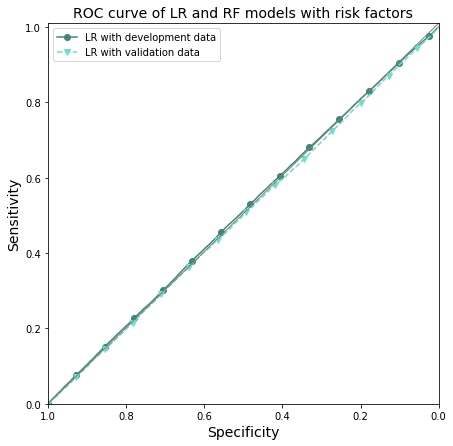

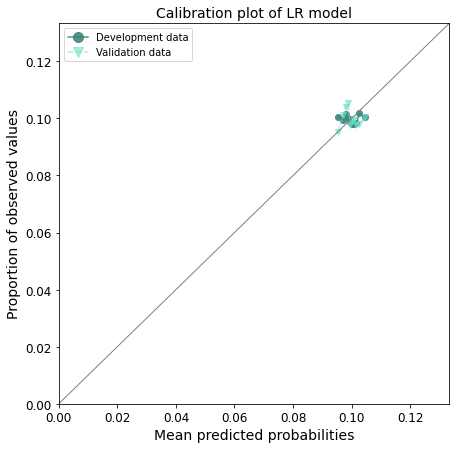

In [39]:
# try:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt, prob_pred_urti_combined_no_abs_incdt_bin = cox_build('urti_combined', 'incdt', data_urti_combined_incdt, data_urti_combined_no_abs_incdt)
# except:
#     print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_deciles('urti_combined', 'incdt_deciles', prob_pred_urti_combined_no_abs_incdt)
#calibration plots of rf and lr with deciles
calibration_rf_lr('urti_combined', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_riskfactors('urti_combined', 'incdt_riskfactors', prob_pred_urti_combined_no_abs_incdt)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('urti_combined', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 48489 total observations, 48193 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 48489
number of events observed = 296
   partial log-likelihood = -3171.97
         time fit was run = 2023-07-31 08:39:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.27       1.31       0.19            -0.11             0.65                 0.89                 1.92
CCI_cat[T.medium]                0.48       1.61       0.20             0.08             0.88                 1.08                 2.40
CCI_cat[T.high]                  0.22       1.25       0.25            -0.27             0.71                 0.77                 2.04
CCI_cat[T.very_high]             0.48       1.62       0.21             0.07             0.90                 1.07                 2.46
age_cat[T.25_34]                -0.15       0.86       0.22            -0.57             0.28                 0.57                 1.32
age_cat[T.35_44]                -0.10       0.91       0.21            -0.51             0.32                 0.60                 1.38
age_cat[T.45_54]                -0.01       0.99       0.21            -0.42             0.40                 0.66                 1.49
age_cat[T.55_64]                 0.01       1.01       0.21            -0.39             0.42                 0.68                 1.52
age_cat[T.65_74]                -0.09       0.91       0.21            -0.51             0.32                 0.60                 1.38
age_cat[T.75_more]              -0.41       0.66       0.23            -0.87             0.04                 0.42                 1.04
antibacterial_brit               0.03       1.03       0.04            -0.05             0.11                 0.95                 1.11
bmi_cat[T.obese]                -0.37       0.69       0.20            -0.76             0.01                 0.47                 1.01
bmi_cat[T.overweight]           -0.06       0.95       0.24            -0.52             0.41                 0.59                 1.51
bmi_cat[T.underweight]          -0.20       0.82       0.36            -0.92             0.51                 0.40                 1.67
bmi_cat[T.unknown]              -0.30       0.74       0.21            -0.72             0.12                 0.49                 1.13
ethnicity[T.other]              -0.03       0.97       0.30            -0.62             0.55                 0.54                 1.73
ethnicity[T.unknown]            -0.14       0.87       0.24            -0.62             0.33                 0.54                 1.39
ethnicity[T.white]               0.01       1.01       0.22            -0.42             0.45                 0.66                 1.56
flu_vaccine[T.yes]              -0.08       0.92       0.20            -0.47             0.31                 0.63                 1.36
imd[T.medium]                   -0.43       0.65       0.19            -0.81            -0.05                 0.45                 0.95
imd[T.unaffluent]               -0.13       0.88       0.18            -0.48             0.22                 0.62                 1.24
imd[T.unknown]                   0.01       1.01       0.27            -0.52             0.54                 0.59                 1.72
imd[T.very_affluent]            -0.26       0.77       0.18            -0.61             0.10                 0.54                 1.11
imd[T.very_unaffluent]          -0.28       0.76       0.18            -0.64             0.08                 0.53                 1.09
region[T.east_midlands]          0.24       1.28  

13055


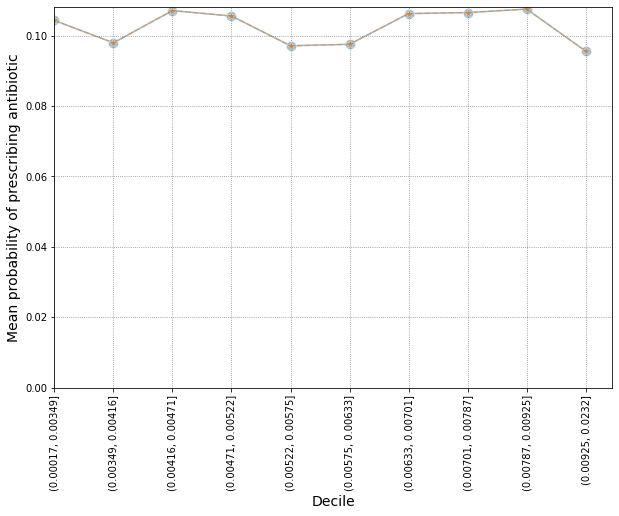


AUROC of LR for deciles with development and validation data: 0.51615 and 0.50347
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00349, 0.00416] -0.031944   -0.040429   -0.023459  0.968561   
bins_(0.00416, 0.00471]  0.026206    0.017699    0.034713  1.026552   
bins_(0.00471, 0.00522]  0.012127    0.003681    0.020573  1.012201   
bins_(0.00522, 0.00575] -0.065088   -0.073574   -0.056603  0.936985   
bins_(0.00575, 0.00633] -0.076246   -0.084705   -0.067787  0.926588   
bins_(0.00633, 0.00701]  0.060509    0.052019    0.068998  1.062377   
bins_(0.00701, 0.00787] -0.010491   -0.018987   -0.001994  0.989564   
bins_(0.00787, 0.00925]  0.052395    0.043929    0.060861  1.053792   
bins_(0.00925, 0.0232]  -0.133986   -0.142491   -0.125481  0.874602   

                         ors_lower  ors_upper  
bins_(0.00349, 0.00416]   0.960377   0.976814  
bins_(0.00416, 0.00471]   1.017857   1.035322  
bins_(0.00471, 0.00522]   1.003688   1.020786  
bins_

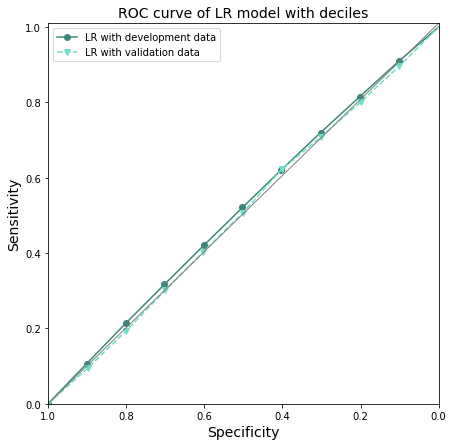

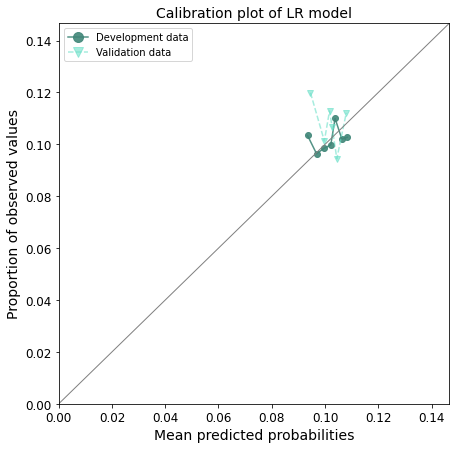


AUROC of LR for risk factors with development and validation data: 0.52109 and 0.50055
LR ORs:
                                  coef  coef_lower  coef_upper       ors  \
age_cat_25_34               -0.034660   -0.044489   -0.024831  0.965934   
age_cat_35_44               -0.106068   -0.115870   -0.096265  0.899364   
age_cat_45_54                0.033254    0.023407    0.043101  1.033813   
age_cat_55_64                0.012207    0.002344    0.022070  1.012282   
age_cat_65_74               -0.014448   -0.024212   -0.004684  0.985656   
age_cat_75_more              0.041058    0.031301    0.050816  1.041913   
sex_male                    -0.028923   -0.034281   -0.023565  0.971491   
CCI_cat_high                 0.019294    0.008899    0.029689  1.019481   
CCI_cat_low                 -0.001516   -0.009262    0.006229  0.998485   
CCI_cat_medium              -0.013742   -0.022326   -0.005159  0.986352   
CCI_cat_very_high            0.023584    0.014481    0.032687  1.023864   
flu

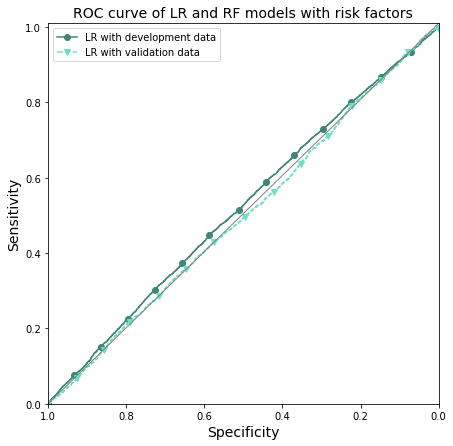

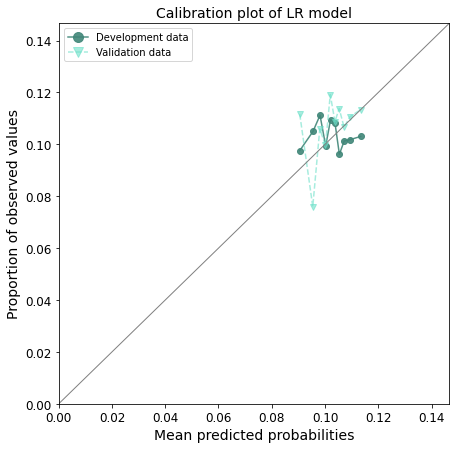

In [40]:
# try:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl, prob_pred_urti_combined_no_abs_prevl_bin = cox_build('urti_combined', 'prevl', data_urti_combined_prevl, data_urti_combined_no_abs_prevl)
# except:
#     print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_deciles('urti_combined', 'prevl_deciles', prob_pred_urti_combined_no_abs_prevl)
#calibration plots of rf and lr with deciles
calibration_rf_lr('urti_combined', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# try:
#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_riskfactors('urti_combined', 'prevl_riskfactors', prob_pred_urti_combined_no_abs_prevl)
#calibration plots of rf and lr with risk factors
calibration_rf_lr('urti_combined', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
# except:
#     print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 114609 total observations, 113938 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 114609
number of events observed = 671
   partial log-likelihood = -7791.02
         time fit was run = 2023-07-31 08:39:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.10       1.10       0.12            -0.14             0.34                 0.87                 1.41
CCI_cat[T.medium]                0.29       1.33       0.13             0.03             0.54                 1.03                 1.72
CCI_cat[T.high]                  0.16       1.17       0.16            -0.15             0.47                 0.86                 1.60
CCI_cat[T.very_high]             0.23       1.26       0.14            -0.04             0.50                 0.96                 1.65
age_cat[T.25_34]                 0.02       1.02       0.14            -0.25             0.29                 0.78                 1.34
age_cat[T.35_44]                -0.15       0.86       0.14            -0.43             0.13                 0.65                 1.14
age_cat[T.45_54]                -0.34       0.71       0.15            -0.64            -0.05                 0.53                 0.95
age_cat[T.55_64]                -0.32       0.73       0.15            -0.61            -0.03                 0.54                 0.97
age_cat[T.65_74]                 0.01       1.01       0.14            -0.26             0.28                 0.77                 1.33
age_cat[T.75_more]               0.01       1.01       0.14            -0.26             0.28                 0.77                 1.32
antibacterial_brit               0.02       1.02       0.03            -0.03             0.07                 0.97                 1.07
bmi_cat[T.obese]                -0.02       0.98       0.14            -0.29             0.26                 0.75                 1.29
bmi_cat[T.overweight]           -0.09       0.91       0.17            -0.43             0.25                 0.65                 1.28
bmi_cat[T.underweight]           0.22       1.24       0.23            -0.23             0.66                 0.79                 1.94
bmi_cat[T.unknown]              -0.29       0.75       0.15            -0.59             0.02                 0.56                 1.02
ethnicity[T.other]               0.50       1.66       0.21             0.10             0.91                 1.10                 2.49
ethnicity[T.unknown]             0.31       1.37       0.18            -0.04             0.67                 0.96                 1.96
ethnicity[T.white]               0.32       1.38       0.17            -0.02             0.66                 0.98                 1.93
flu_vaccine[T.yes]              -0.01       0.99       0.13            -0.27             0.24                 0.76                 1.27
imd[T.medium]                   -0.04       0.96       0.12            -0.28             0.20                 0.75                 1.22
imd[T.unaffluent]               -0.06       0.94       0.12            -0.30             0.19                 0.74                 1.20
imd[T.unknown]                  -0.03       0.97       0.19            -0.41             0.35                 0.66                 1.42
imd[T.very_affluent]            -0.07       0.93       0.12            -0.31             0.17                 0.73                 1.19
imd[T.very_unaffluent]          -0.08       0.92       0.12            -0.33             0.16                 0.72                 1.17
region[T.east_midlands]          0.11       1.1

13066


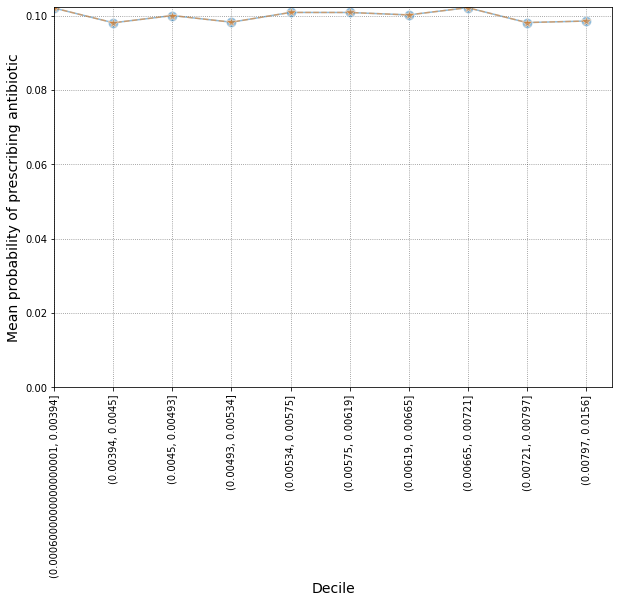


AUROC of LR for deciles with development and validation data: 0.50542 and 0.49723
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00394, 0.0045]  -0.027485   -0.032984   -0.021986  0.972889   
bins_(0.0045, 0.00493]   0.001353   -0.004166    0.006872  1.001354   
bins_(0.00493, 0.00534] -0.048731   -0.054226   -0.043237  0.952437   
bins_(0.00534, 0.00575] -0.016507   -0.022003   -0.011011  0.983628   
bins_(0.00575, 0.00619] -0.035687   -0.041153   -0.030221  0.964942   
bins_(0.00619, 0.00665] -0.006067   -0.011561   -0.000573  0.993951   
bins_(0.00665, 0.00721] -0.004697   -0.010216    0.000822  0.995314   
bins_(0.00721, 0.00797] -0.041319   -0.046805   -0.035832  0.959523   
bins_(0.00797, 0.0156]  -0.049497   -0.054979   -0.044015  0.951708   

                         ors_lower  ors_upper  
bins_(0.00394, 0.0045]    0.967554   0.978254  
bins_(0.0045, 0.00493]    0.995843   1.006895  
bins_(0.00493, 0.00534]   0.947218   0.957685  
bins_

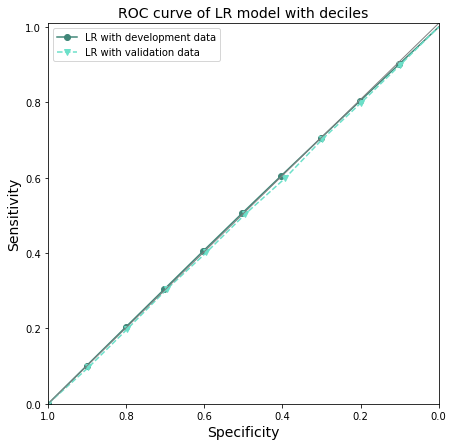

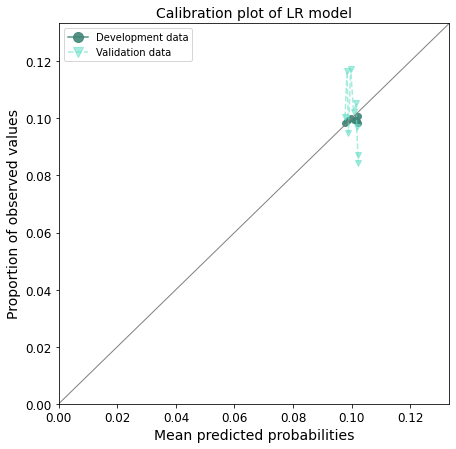

In [41]:
# try:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_prepandemic, prob_pred_urti_combined_no_abs_incdt_prepandemic_bin = cox_build('urti_combined', 'incdt_prepandemic', data_urti_combined_incdt_prepandemic, data_urti_combined_no_abs_incdt_prepandemic)
# except:
#     print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('urti_combined', 'incdt_prepandemic_deciles', prob_pred_urti_combined_no_abs_incdt_prepandemic)
#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic)#, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 103955 total observations, 103267 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 103955
number of events observed = 688
   partial log-likelihood = -7926.68
         time fit was run = 2023-07-31 08:39:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.11            -0.24             0.20                 0.78                 1.22
CCI_cat[T.medium]                0.06       1.06       0.12            -0.18             0.30                 0.83                 1.35
CCI_cat[T.high]                 -0.13       0.88       0.16            -0.44             0.17                 0.65                 1.19
CCI_cat[T.very_high]            -0.06       0.94       0.13            -0.32             0.20                 0.72                 1.22
age_cat[T.25_34]                 0.04       1.04       0.14            -0.24             0.32                 0.78                 1.38
age_cat[T.35_44]                 0.05       1.05       0.14            -0.23             0.33                 0.79                 1.39
age_cat[T.45_54]                 0.18       1.20       0.14            -0.09             0.45                 0.91                 1.57
age_cat[T.55_64]                -0.04       0.96       0.15            -0.32             0.25                 0.72                 1.28
age_cat[T.65_74]                -0.15       0.86       0.15            -0.44             0.15                 0.64                 1.16
age_cat[T.75_more]               0.06       1.06       0.14            -0.22             0.34                 0.80                 1.41
antibacterial_brit               0.03       1.03       0.03            -0.02             0.08                 0.98                 1.09
bmi_cat[T.obese]                -0.04       0.96       0.14            -0.32             0.24                 0.73                 1.27
bmi_cat[T.overweight]            0.12       1.13       0.17            -0.21             0.45                 0.81                 1.57
bmi_cat[T.underweight]          -0.04       0.96       0.25            -0.54             0.45                 0.59                 1.57
bmi_cat[T.unknown]              -0.14       0.87       0.15            -0.44             0.16                 0.64                 1.18
ethnicity[T.other]              -0.06       0.94       0.20            -0.46             0.34                 0.63                 1.40
ethnicity[T.unknown]            -0.13       0.88       0.17            -0.46             0.19                 0.63                 1.21
ethnicity[T.white]               0.12       1.13       0.15            -0.17             0.42                 0.84                 1.52
flu_vaccine[T.yes]               0.03       1.03       0.13            -0.22             0.28                 0.80                 1.32
imd[T.medium]                   -0.08       0.92       0.12            -0.32             0.16                 0.73                 1.17
imd[T.unaffluent]               -0.18       0.83       0.12            -0.43             0.06                 0.65                 1.06
imd[T.unknown]                   0.02       1.02       0.18            -0.34             0.39                 0.71                 1.47
imd[T.very_affluent]            -0.06       0.94       0.12            -0.30             0.18                 0.74                 1.19
imd[T.very_unaffluent]          -0.15       0.86       0.12            -0.39             0.10                 0.68                 1.10
region[T.east_midlands]          0.19       1.2

13059


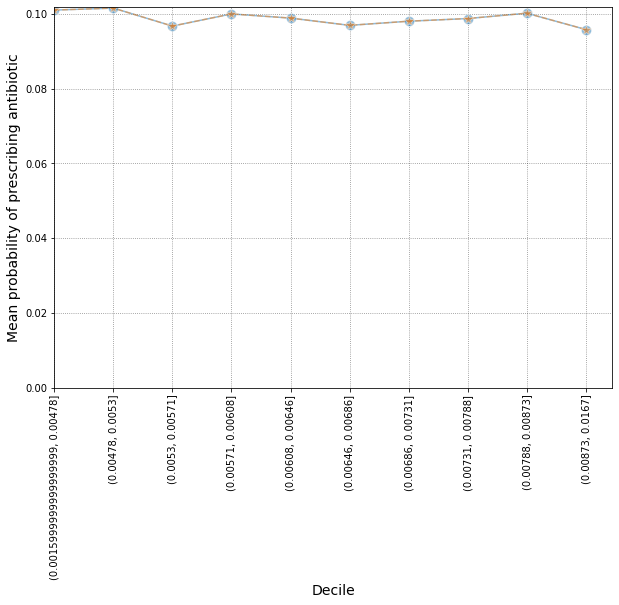


AUROC of LR for deciles with development and validation data: 0.50728 and 0.49485
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00478, 0.0053]  -0.022732   -0.028454   -0.017010  0.977525   
bins_(0.0053, 0.00571]  -0.059725   -0.065467   -0.053982  0.942024   
bins_(0.00571, 0.00608] -0.027635   -0.033384   -0.021886  0.972743   
bins_(0.00608, 0.00646] -0.050613   -0.056363   -0.044862  0.950647   
bins_(0.00646, 0.00686] -0.085200   -0.090949   -0.079451  0.918329   
bins_(0.00686, 0.00731] -0.045034   -0.050761   -0.039308  0.955965   
bins_(0.00731, 0.00788] -0.059339   -0.065082   -0.053596  0.942387   
bins_(0.00788, 0.00873]  0.001348   -0.004359    0.007054  1.001348   
bins_(0.00873, 0.0167]  -0.043756   -0.049496   -0.038016  0.957188   

                         ors_lower  ors_upper  
bins_(0.00478, 0.0053]    0.971947   0.983134  
bins_(0.0053, 0.00571]    0.936630   0.947449  
bins_(0.00571, 0.00608]   0.967167   0.978352  
bins_

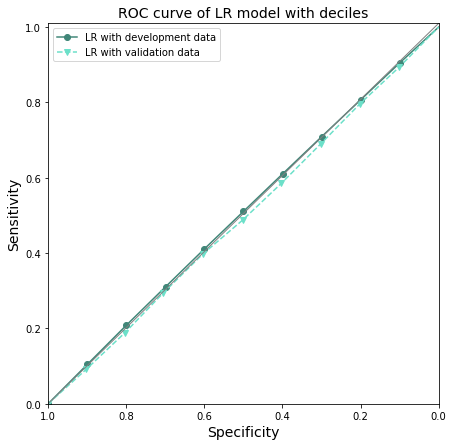

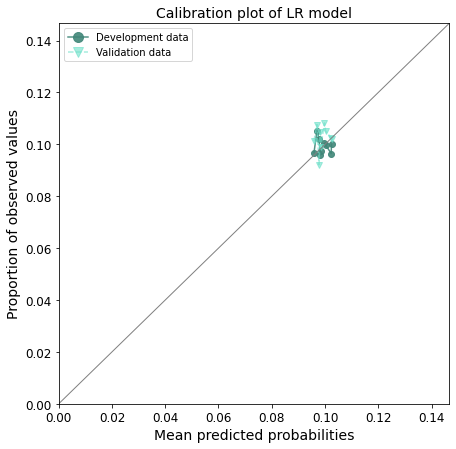

In [42]:
# try:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_during_pandemic, prob_pred_urti_combined_no_abs_incdt_during_pandemic_bin = cox_build('urti_combined', 'incdt_during_pandemic', data_urti_combined_incdt_during_pandemic, data_urti_combined_no_abs_incdt_during_pandemic)
# except:
#     print("error_1: cox model did not converge or failed to finalise.")
    
# try:
#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('urti_combined', 'incdt_during_pandemic_deciles', prob_pred_urti_combined_no_abs_incdt_during_pandemic)
#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic)#, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 184209 total observations, 182933 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 184209
number of events observed = 1276
   partial log-likelihood = -15439.93
         time fit was run = 2023-07-31 08:40:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.09            -0.14             0.19                 0.87                 1.21
CCI_cat[T.medium]                0.04       1.04       0.09            -0.14             0.23                 0.87                 1.26
CCI_cat[T.high]                  0.16       1.17       0.11            -0.06             0.37                 0.94                 1.44
CCI_cat[T.very_high]             0.15       1.16       0.10            -0.04             0.34                 0.96                 1.41
age_cat[T.25_34]                -0.15       0.86       0.11            -0.37             0.07                 0.69                 1.07
age_cat[T.35_44]                 0.05       1.05       0.11            -0.15             0.26                 0.86                 1.30
age_cat[T.45_54]                 0.08       1.09       0.11            -0.12             0.29                 0.89                 1.34
age_cat[T.55_64]                 0.08       1.08       0.10            -0.13             0.28                 0.88                 1.32
age_cat[T.65_74]                 0.17       1.18       0.10            -0.03             0.37                 0.97                 1.45
age_cat[T.75_more]               0.06       1.06       0.11            -0.14             0.27                 0.87                 1.31
antibacterial_brit               0.02       1.02       0.02            -0.02             0.06                 0.98                 1.06
bmi_cat[T.obese]                 0.05       1.05       0.11            -0.16             0.26                 0.85                 1.30
bmi_cat[T.overweight]           -0.09       0.91       0.13            -0.36             0.17                 0.70                 1.19
bmi_cat[T.underweight]          -0.13       0.88       0.20            -0.52             0.25                 0.60                 1.29
bmi_cat[T.unknown]               0.12       1.13       0.11            -0.10             0.34                 0.90                 1.41
ethnicity[T.other]               0.08       1.08       0.14            -0.21             0.36                 0.81                 1.43
ethnicity[T.unknown]            -0.05       0.95       0.12            -0.28             0.18                 0.75                 1.20
ethnicity[T.white]               0.05       1.06       0.11            -0.16             0.27                 0.85                 1.31
flu_vaccine[T.yes]              -0.11       0.90       0.10            -0.30             0.08                 0.74                 1.08
imd[T.medium]                   -0.07       0.93       0.09            -0.25             0.11                 0.78                 1.12
imd[T.unaffluent]               -0.05       0.95       0.09            -0.22             0.13                 0.80                 1.14
imd[T.unknown]                   0.01       1.01       0.14            -0.26             0.28                 0.77                 1.32
imd[T.very_affluent]            -0.09       0.91       0.09            -0.27             0.09                 0.77                 1.09
imd[T.very_unaffluent]          -0.03       0.97       0.09            -0.21             0.15                 0.81                 1.16
region[T.east_midlands]         -0.12       0

13070


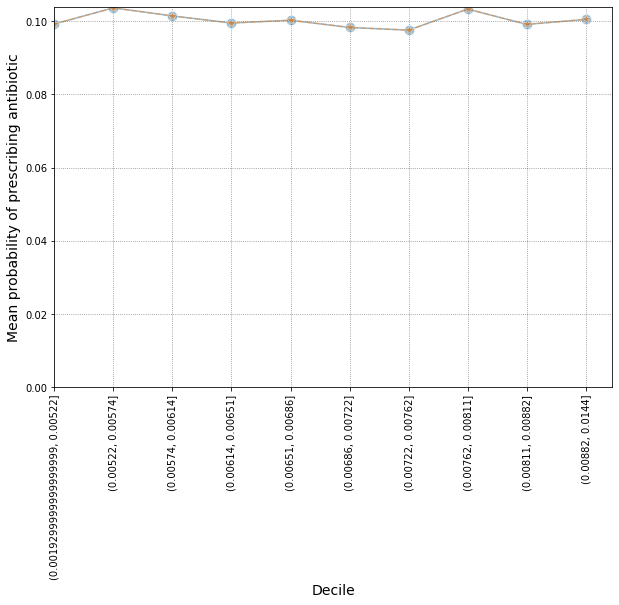


AUROC of LR for deciles with development and validation data: 0.50646 and 0.50140
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00522, 0.00574]  0.046913    0.042561    0.051265  1.048031   
bins_(0.00574, 0.00614]  0.007309    0.002976    0.011642  1.007336   
bins_(0.00614, 0.00651]  0.008467    0.004140    0.012794  1.008503   
bins_(0.00651, 0.00686]  0.004259   -0.000079    0.008597  1.004268   
bins_(0.00686, 0.00722] -0.003764   -0.008108    0.000580  0.996243   
bins_(0.00722, 0.00762] -0.046789   -0.051123   -0.042454  0.954289   
bins_(0.00762, 0.00811]  0.034512    0.030170    0.038854  1.035114   
bins_(0.00811, 0.00882] -0.015873   -0.020227   -0.011520  0.984252   
bins_(0.00882, 0.0144]  -0.003602   -0.007948    0.000743  0.996404   

                         ors_lower  ors_upper  
bins_(0.00522, 0.00574]   1.043479   1.052602  
bins_(0.00574, 0.00614]   1.002980   1.011710  
bins_(0.00614, 0.00651]   1.004149   1.012876  
bins_

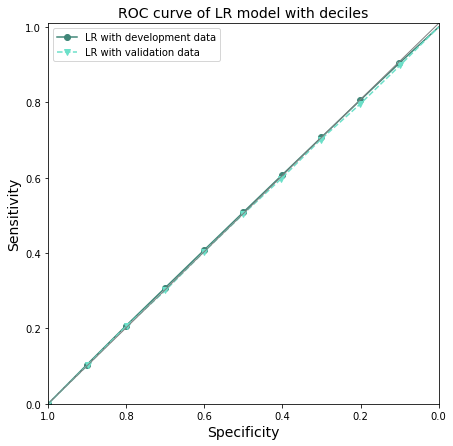

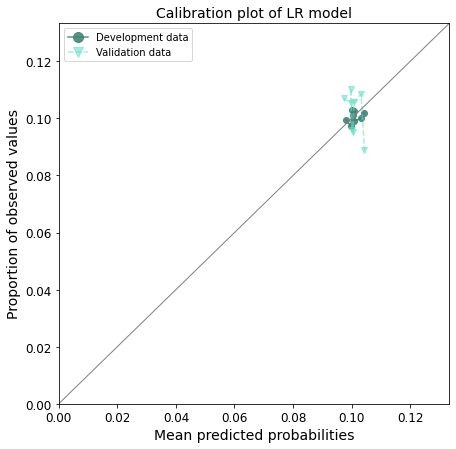

In [43]:
# try:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown, prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown_bin = cox_build('urti_combined', 'incdt_post_2nd_lockdown', data_urti_combined_incdt_post_2nd_lockdown, data_urti_combined_no_abs_incdt_post_2nd_lockdown)
# except:
#     print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('urti_combined', 'incdt_post_2nd_lockdown_deciles', prob_pred_urti_combined_no_abs_incdt_post_2nd_lockdown)
#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown)#, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 12588 total observations, 12530 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 12588
number of events observed = 58
   partial log-likelihood = -532.60
         time fit was run = 2023-07-31 08:40:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.43            -0.78             0.89                 0.46                 2.45
CCI_cat[T.medium]                0.02       1.02       0.48            -0.91             0.95                 0.40                 2.59
CCI_cat[T.high]                  0.50       1.64       0.50            -0.49             1.48                 0.62                 4.38
CCI_cat[T.very_high]             0.59       1.80       0.44            -0.28             1.46                 0.75                 4.30
age_cat[T.25_34]                -0.09       0.91       0.49            -1.05             0.86                 0.35                 2.37
age_cat[T.35_44]                -0.39       0.68       0.53            -1.42             0.65                 0.24                 1.91
age_cat[T.45_54]                 0.14       1.15       0.46            -0.76             1.05                 0.47                 2.85
age_cat[T.55_64]                 0.03       1.03       0.47            -0.89             0.96                 0.41                 2.61
age_cat[T.65_74]                 0.16       1.17       0.46            -0.75             1.06                 0.47                 2.88
age_cat[T.75_more]              -0.38       0.69       0.53            -1.41             0.66                 0.24                 1.93
antibacterial_brit              -0.03       0.97       0.09            -0.21             0.16                 0.81                 1.17
bmi_cat[T.obese]                 0.03       1.03       0.54            -1.03             1.08                 0.36                 2.94
bmi_cat[T.overweight]            0.44       1.56       0.60            -0.74             1.62                 0.48                 5.07
bmi_cat[T.underweight]           1.09       2.98       0.67            -0.23             2.41                 0.80                11.13
bmi_cat[T.unknown]               0.08       1.08       0.57            -1.04             1.20                 0.35                 3.33
ethnicity[T.other]              -0.02       0.98       0.71            -1.40             1.37                 0.25                 3.95
ethnicity[T.unknown]             0.38       1.46       0.55            -0.70             1.46                 0.50                 4.30
ethnicity[T.white]              -0.04       0.96       0.53            -1.08             1.00                 0.34                 2.73
flu_vaccine[T.yes]               0.16       1.18       0.40            -0.63             0.95                 0.53                 2.59
imd[T.medium]                   -0.00       1.00       0.43            -0.84             0.83                 0.43                 2.30
imd[T.unaffluent]                0.36       1.43       0.39            -0.41             1.13                 0.66                 3.09
imd[T.unknown]                   0.03       1.03       0.65            -1.25             1.31                 0.29                 3.71
imd[T.very_affluent]            -0.25       0.78       0.45            -1.14             0.63                 0.32                 1.87
imd[T.very_unaffluent]          -0.37       0.69       0.47            -1.28             0.54                 0.28                 1.72
region[T.east_midlands]          0.41       1.51    

13046


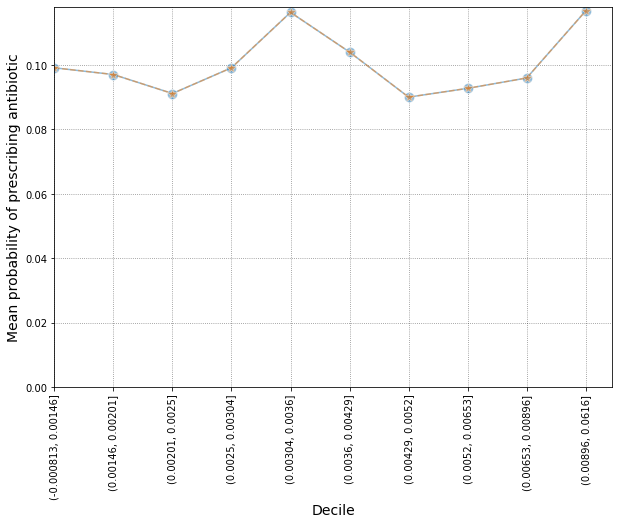


AUROC of LR for deciles with development and validation data: 0.53275 and 0.50659
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00146, 0.00201] -0.066171   -0.082850   -0.049492  0.935971   
bins_(0.00201, 0.0025]  -0.177556   -0.194216   -0.160895  0.837314   
bins_(0.0025, 0.00304]  -0.116422   -0.133029   -0.099815  0.890099   
bins_(0.00304, 0.0036]   0.169163    0.152573    0.185752  1.184313   
bins_(0.0036, 0.00429]   0.012268   -0.004192    0.028729  1.012344   
bins_(0.00429, 0.0052]  -0.196472   -0.213056   -0.179889  0.821624   
bins_(0.0052, 0.00653]  -0.120035   -0.136678   -0.103393  0.886889   
bins_(0.00653, 0.00896] -0.145236   -0.161945   -0.128528  0.864818   
bins_(0.00896, 0.0616]   0.092644    0.076067    0.109222  1.097071   

                         ors_lower  ors_upper  
bins_(0.00146, 0.00201]   0.920490   0.951713  
bins_(0.00201, 0.0025]    0.823480   0.851381  
bins_(0.0025, 0.00304]    0.875439   0.905005  
bins_

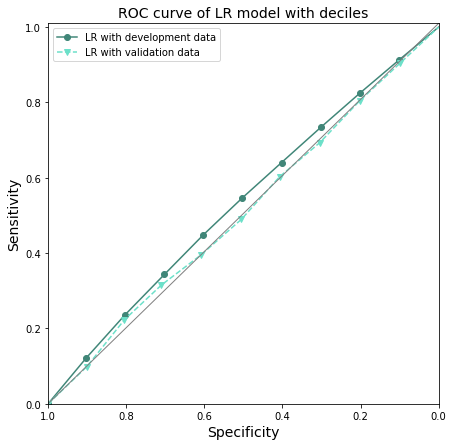

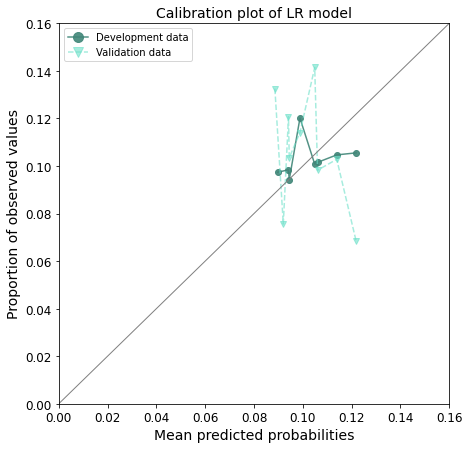

In [44]:
# try:    
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_prepandemic, prob_pred_urti_combined_no_abs_prevl_prepandemic_bin = cox_build('urti_combined', 'prevl_prepandemic', data_urti_combined_prevl_prepandemic, data_urti_combined_no_abs_prevl_prepandemic)
# except:
#     print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('urti_combined', 'prevl_prepandemic_deciles', prob_pred_urti_combined_no_abs_prevl_prepandemic)
#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic)#, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 11498 total observations, 11431 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 11498
number of events observed = 67
   partial log-likelihood = -612.06
         time fit was run = 2023-07-31 08:40:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.40            -0.92             0.63                 0.40                 1.87
CCI_cat[T.medium]                0.14       1.15       0.41            -0.68             0.95                 0.51                 2.58
CCI_cat[T.high]                  0.17       1.18       0.49            -0.80             1.14                 0.45                 3.12
CCI_cat[T.very_high]             0.59       1.81       0.40            -0.18             1.37                 0.83                 3.93
age_cat[T.25_34]                 0.29       1.33       0.47            -0.62             1.20                 0.54                 3.32
age_cat[T.35_44]                 0.15       1.17       0.48            -0.78             1.09                 0.46                 2.96
age_cat[T.45_54]                 0.24       1.27       0.47            -0.67             1.15                 0.51                 3.16
age_cat[T.55_64]                 0.33       1.39       0.47            -0.59             1.24                 0.56                 3.45
age_cat[T.65_74]                 0.33       1.39       0.47            -0.59             1.24                 0.56                 3.45
age_cat[T.75_more]              -0.50       0.61       0.57            -1.62             0.62                 0.20                 1.85
antibacterial_brit               0.06       1.06       0.08            -0.11             0.22                 0.90                 1.25
bmi_cat[T.obese]                -0.26       0.77       0.45            -1.14             0.62                 0.32                 1.85
bmi_cat[T.overweight]            0.15       1.16       0.52            -0.87             1.16                 0.42                 3.20
bmi_cat[T.underweight]           0.28       1.33       0.71            -1.11             1.67                 0.33                 5.34
bmi_cat[T.unknown]              -0.01       0.99       0.47            -0.93             0.91                 0.39                 2.48
ethnicity[T.other]              -0.69       0.50       0.71            -2.08             0.70                 0.13                 2.01
ethnicity[T.unknown]            -0.23       0.79       0.48            -1.18             0.71                 0.31                 2.04
ethnicity[T.white]              -0.07       0.93       0.44            -0.93             0.78                 0.39                 2.19
flu_vaccine[T.yes]              -0.33       0.72       0.47            -1.25             0.58                 0.29                 1.78
imd[T.medium]                   -0.72       0.49       0.41            -1.52             0.08                 0.22                 1.08
imd[T.unaffluent]               -0.20       0.82       0.35            -0.89             0.49                 0.41                 1.63
imd[T.unknown]                  -0.74       0.48       0.75            -2.20             0.73                 0.11                 2.06
imd[T.very_affluent]            -0.31       0.73       0.36            -1.03             0.40                 0.36                 1.49
imd[T.very_unaffluent]          -0.58       0.56       0.40            -1.36             0.19                 0.26                 1.21
region[T.east_midlands]         -0.15       0.86    

13062


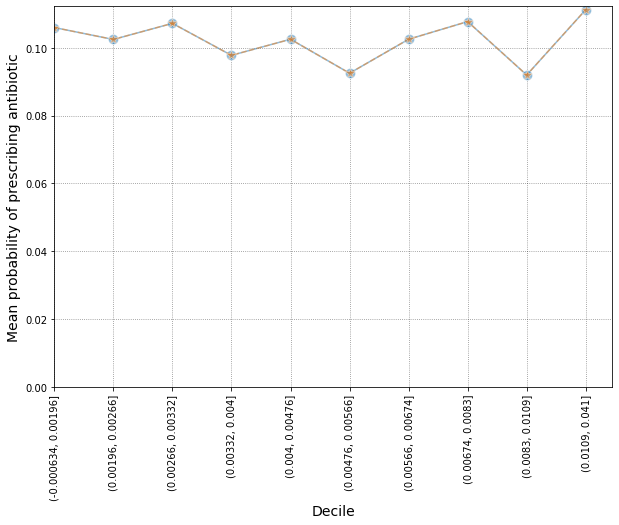


AUROC of LR for deciles with development and validation data: 0.51988 and 0.51228
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00196, 0.00266] -0.009852   -0.027485    0.007781  0.990196   
bins_(0.00266, 0.00332]  0.033307    0.015737    0.050878  1.033868   
bins_(0.00332, 0.004]   -0.014194   -0.031862    0.003474  0.985906   
bins_(0.004, 0.00476]   -0.001762   -0.019056    0.015532  0.998239   
bins_(0.00476, 0.00566] -0.108272   -0.125911   -0.090632  0.897384   
bins_(0.00566, 0.00674]  0.028093    0.010564    0.045622  1.028491   
bins_(0.00674, 0.0083]   0.112101    0.094668    0.129535  1.118626   
bins_(0.0083, 0.0109]   -0.106327   -0.123614   -0.089040  0.899130   
bins_(0.0109, 0.041]     0.119921    0.102427    0.137416  1.127408   

                         ors_lower  ors_upper  
bins_(0.00196, 0.00266]   0.972889   1.007811  
bins_(0.00266, 0.00332]   1.015862   1.052194  
bins_(0.00332, 0.004]     0.968641   1.003480  
bins_

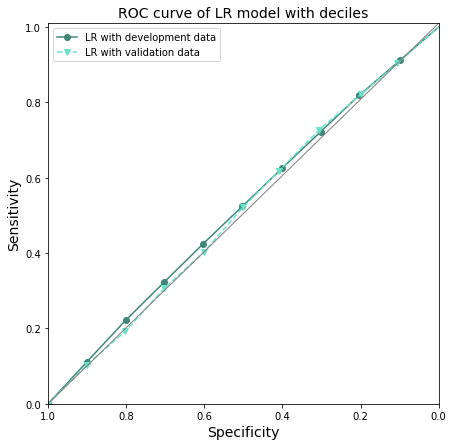

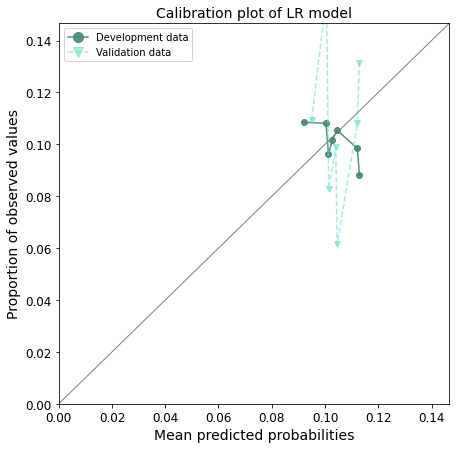

In [45]:
# try:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_during_pandemic, prob_pred_urti_combined_no_abs_prevl_during_pandemic_bin = cox_build('urti_combined', 'prevl_during_pandemic', data_urti_combined_prevl_during_pandemic, data_urti_combined_no_abs_prevl_during_pandemic)
# except:
#     print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('urti_combined', 'prevl_during_pandemic_deciles', prob_pred_urti_combined_no_abs_prevl_during_pandemic)
#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic)#, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 20447 total observations, 20300 right-censored observations>
             duration col = 'duration_urti_combined_admitted'
                event col = 'event_urti_combined_admitted'
      baseline estimation = breslow
   number of observations = 20447
number of events observed = 147
   partial log-likelihood = -1442.71
         time fit was run = 2023-07-31 08:40:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.23       1.26       0.27            -0.30             0.76                 0.74                 2.13
CCI_cat[T.medium]                0.52       1.68       0.28            -0.03             1.07                 0.97                 2.91
CCI_cat[T.high]                 -0.19       0.82       0.39            -0.96             0.57                 0.38                 1.77
CCI_cat[T.very_high]             0.43       1.53       0.30            -0.15             1.01                 0.86                 2.74
age_cat[T.25_34]                -0.59       0.55       0.32            -1.23             0.04                 0.29                 1.05
age_cat[T.35_44]                -0.07       0.93       0.28            -0.62             0.47                 0.54                 1.61
age_cat[T.45_54]                -0.31       0.74       0.30            -0.90             0.29                 0.41                 1.33
age_cat[T.55_64]                -0.14       0.87       0.29            -0.71             0.42                 0.49                 1.52
age_cat[T.65_74]                -0.44       0.65       0.31            -1.04             0.16                 0.35                 1.18
age_cat[T.75_more]              -0.24       0.79       0.29            -0.82             0.33                 0.44                 1.40
antibacterial_brit               0.00       1.00       0.06            -0.11             0.12                 0.89                 1.12
bmi_cat[T.obese]                -0.03       0.97       0.30            -0.61             0.56                 0.54                 1.75
bmi_cat[T.overweight]            0.10       1.11       0.36            -0.60             0.80                 0.55                 2.23
bmi_cat[T.underweight]          -0.82       0.44       0.76            -2.31             0.67                 0.10                 1.95
bmi_cat[T.unknown]              -0.31       0.74       0.33            -0.96             0.35                 0.38                 1.41
ethnicity[T.other]               0.48       1.62       0.41            -0.32             1.28                 0.73                 3.61
ethnicity[T.unknown]             0.17       1.18       0.35            -0.53             0.86                 0.59                 2.37
ethnicity[T.white]               0.08       1.09       0.34            -0.57             0.74                 0.56                 2.10
flu_vaccine[T.yes]               0.06       1.06       0.27            -0.46             0.58                 0.63                 1.78
imd[T.medium]                   -0.52       0.60       0.31            -1.12             0.08                 0.33                 1.09
imd[T.unaffluent]                0.05       1.05       0.26            -0.46             0.56                 0.63                 1.75
imd[T.unknown]                  -0.03       0.97       0.42            -0.85             0.80                 0.43                 2.22
imd[T.very_affluent]             0.00       1.00       0.26            -0.51             0.51                 0.60                 1.67
imd[T.very_unaffluent]           0.20       1.22       0.25            -0.30             0.70                 0.74                 2.01
region[T.east_midlands]         -0.18       0.83  

13058


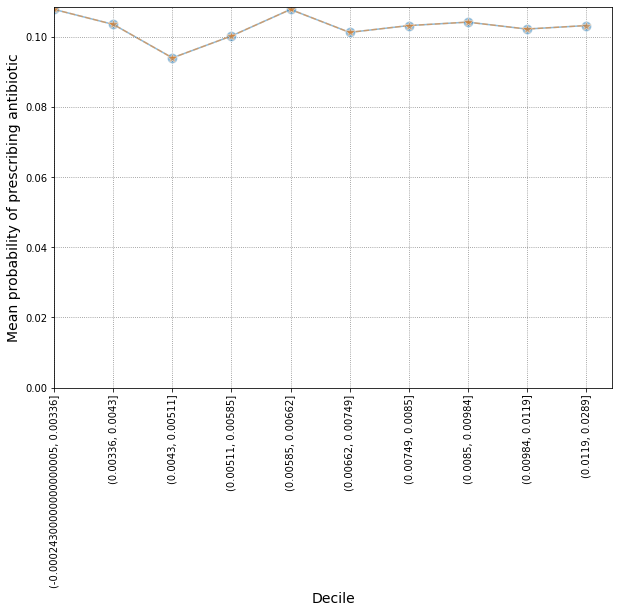


AUROC of LR for deciles with development and validation data: 0.51373 and 0.48660
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00336, 0.0043]   0.028655    0.015590    0.041720  1.029070   
bins_(0.0043, 0.00511]  -0.173491   -0.186700   -0.160283  0.840724   
bins_(0.00511, 0.00585] -0.044406   -0.057533   -0.031279  0.956566   
bins_(0.00585, 0.00662]  0.003540   -0.009675    0.016755  1.003546   
bins_(0.00662, 0.00749] -0.002860   -0.016037    0.010317  0.997144   
bins_(0.00749, 0.0085]   0.002338   -0.010732    0.015408  1.002341   
bins_(0.0085, 0.00984]  -0.056936   -0.069990   -0.043883  0.944654   
bins_(0.00984, 0.0119]  -0.062303   -0.075411   -0.049196  0.939598   
bins_(0.0119, 0.0289]    0.013885    0.000664    0.027105  1.013982   

                         ors_lower  ors_upper  
bins_(0.00336, 0.0043]    1.015713   1.042602  
bins_(0.0043, 0.00511]    0.829692   0.851903  
bins_(0.00511, 0.00585]   0.944090   0.969206  
bins_

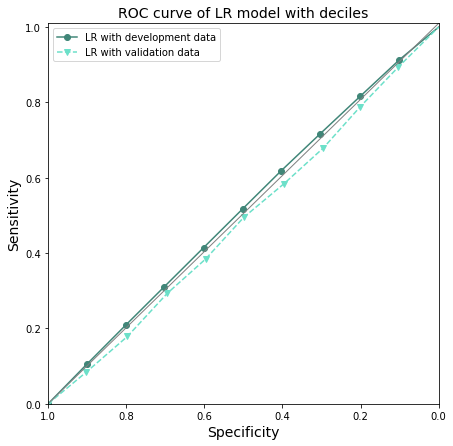

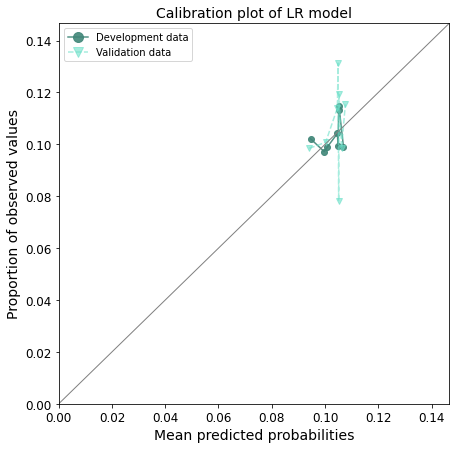

In [46]:
# try:
#build cox model for hosp prediction using non ab users' data
prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown, prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown_bin = cox_build('urti_combined', 'prevl_post_2nd_lockdown', data_urti_combined_prevl_post_2nd_lockdown, data_urti_combined_no_abs_prevl_post_2nd_lockdown)
# except:
#     print("error_1: cox model did not converge or failed to finalise.")

# try:
#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('urti_combined', 'prevl_post_2nd_lockdown_deciles', prob_pred_urti_combined_no_abs_prevl_post_2nd_lockdown)
#calibration plots of rf and lr
calibration_rf_lr('urti_combined', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown)#, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)
# except:
#     print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")